# Echobox News Articles

## Table Of Contents
[Import Packages](#import)
    
1. [Exploratory Data Analysis](#eda)
    
2. [Initial Challenges](#challenges)

3. [Clustering Based On Vector Embeddings](#3)
    - 3.1 [Preprocessing and Applying Pre-Trained Model](#3.1)
    - 3.2 [Dimensionality Reduction](#3.2)
    - 3.3 [Clusterisation](#3.3)
    - 3.4 [Evaluation](#3.4)
    
    
4. [Hiearchical Clustering](#4)
    - 4.1 [Preprocessing and Finding NER (Named Entity Recognition)](#4.1)
    - 4.2 [Intermediate Dimensionality Reduction](#4.2)
    - 4.3 [First Stage Clustering](#4.3)
    - 4.4 [Evaluate First Stage Clustering to Prepare Data for Next Stage](#4.4)
    - 4.5 [Second Stage Clustering](#4.5)
    - 4.6 [Final Evaluation](#4.6)
 
 
5. [Feature Extraction](#feature)

5. [Conclusion and Closing Remarks](#conclusion)

## Import Packages (spacy, sklearn)<a class="anchor" id="import"></a>

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.cluster import DBSCAN
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
import spacy

stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
nlp = spacy.load('en_core_web_lg')

## 1. Exploratory Data Analysis<a class="anchor" id="eda"></a>

In [2]:
# Load Data
articles = pd.read_csv("20190710 - DS Challenge - Breaking News Articles Detection - DSChallengeArticleId.csv")

In [3]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13022 entries, 0 to 13021
Data columns (total 6 columns):
ArticleId               13022 non-null object
ArticleURL              13022 non-null object
ArticleTitle            13022 non-null object
ArticleDescription      9594 non-null object
ArticlePublishedTime    13022 non-null int64
EventId                 0 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 610.5+ KB


In [4]:
articles.head(10)

,ArticleId,ArticleURL,ArticleTitle,ArticleDescription,ArticlePublishedTime,EventId
0,5cd7ed707ddacd3b2b3b549e,https://www.bbc.co.uk/news/uk-england-suffolk-...,Lowestoft sea wall fall cyclist rescued by friend,Coastguards praise the boy's friend for his ac...,1557653530,NaN
1,5cd7e83beb96a44751294217,https://www.highsnobiety.com/p/met-gala-best-c...,The Met Gala & ‘Game of Thrones’ Feature in Th...,"Once again, our ever-sarcastic readership have...",1557653563,NaN
2,5cd7e99a8e662d1e4435cb3d,https://www.mirror.co.uk/news/uk-news/boy-dies...,Boy dies on prom day after allergic reaction t...,Joe Dale's family have spoken out about losing...,1557653574,NaN
3,5cd7f6dd7ddacd3b2b3b56ab,https://www.independent.co.uk/voices/paddy-jac...,Paddy Jackson’s return to Rugby is yet more pr...,He may have been found not guilty of rape last...,1557653588,NaN
4,5cd7e89c8e662d1e4435cb13,https://www.standard.co.uk/showbiz/celebrity-n...,BAFTA TV Awards 2019: Stars prepare for glitzy...,Stars are preparing for Sunday night s TV Baft...,1557653610,NaN
5,5cd7e8ad8e662d1e4435cb18,https://newsinfo.inquirer.net/1117187/look-poe...,LOOK: Poe shares son’s fave photo of her on Mo...,"Sen. Grace Poe, who is running for re-election...",1557653627,NaN
6,5cd7eb788e662d1e4435cb9c,https://www.mirror.co.uk/sport/football/news/p...,Pep Guardiola 'bans Man City staff from checki...,Man City will win the Premier League with vict...,1557653639,NaN
7,5cd8124b7ddacd3b2b3b5cda,https://virginradio.co.uk/highlights/lewis-cap...,"Lewis Capaldi, Olivia Wilde, Mena Massoud & MO...",HighlightsThe cavalcade of stars continued thi...,1557653674,NaN
8,5cd7e90e7ddacd3b2b3b53b4,https://www.smh.com.au/sport/soccer/wanderers-...,Wanderers face leadership crisis as captain Ha...,Western Sydney Wanderers captain Brendan Hamil...,1557653689,NaN
9,5cd7ea8c7ddacd3b2b3b540b,https://ahvalnews.com/berat-albayrak/turkeys-f...,Turkey's finance minister signals inflation ra...,Turkey's finance minister on Sunday said the c...,1557653697,NaN


In [5]:
# find duplicates
articles[articles.duplicated()].sum()

ArticleId               0.0
ArticleURL              0.0
ArticleTitle            0.0
ArticleDescription      0.0
ArticlePublishedTime    0.0
EventId                 0.0
dtype: float64

In [6]:
# Convert theunix timestamp to datetime item in python
articles['ArticlePublishedTimeDateTime'] = articles['ArticlePublishedTime'].apply(lambda x: datetime.fromtimestamp(int(x)))

In [7]:
# Fill the empty article descriptions with an empty string to avoid errors
articles['ArticleDescription'].fillna("", inplace = True)

In [8]:
# Get the range published times of articles
max(articles['ArticlePublishedTimeDateTime'])-min(articles['ArticlePublishedTimeDateTime'])

Timedelta('1 days 23:58:56')

## 2. Initial Challenges<a class="anchor" id="challenges"></a>
There are a couple of interesting parameters surrounding the dataset
1. There are only 13,000 articles in the dataset
    - This makes it difficult to train a dictionary with word2vec model as there is insufficient data to form a sufficiently coherent dictionary
2. News articles have a wide variety of topics from sports to politics to celebrity news
    - NLP models are usually specific to a dataset as it is difficult to generate/train a model that is generic enough that can be applied to all texts
    - The wide variety of topics makes it difficult for any sort of dictinoary not trained specifically on this dataset to perform well
3. Not all articles have descriptions
    - My initial thought was to have a hierachical method of clustering using both the article titles and descriptions. With only slightly over half of the articles having descriptions this is not a viable solution
4. The dataset is completely unsupervised
    - This aspect makes it difficult to discern between articles that report major events.
    - Without labelled data it is not trivial to train a model that is able to differentiate the major articles from the rest.
    - From an unsupervised point of view, what is considered a 'major' article? Without labelled data we will have to work based off the features of the article vectors alone which is difficult to understand and represent
5. The range of dates for the article is only roughly 2 days
    - I was also considering clustering articles based on time of publish but the timeframe is very short. Will need to explore to determine if it is a good method of splitting the articles.

## 3. Clustering Based On Vector Embeddings<a class="anchor" id="3"></a>

1. Apply preprocessing get vector representation of articles
2. Perform dimensionality reduction to reduce the vectors from 300 features to 2 using PCA and TSNE
3. Perform clusterisation using DBSCAN algorithm
4. Evaluate the clusterisation using similarities

### 3.1 Preprocessing and Applying Pre-Trained Model<a class="anchor" id="3.1"></a>
Preprocessing steps involve removing stop words and applying a pretrained 'spacy' model to get the vector embeddings for the articles. The pre-trained model I will be using was trained on Wikipedia articles and has over 1,000,000 different words. Although not perfect, it should at least be able to represent each word of the article.

In [9]:
# Preprocessing

sent_vec={}
docs = []
type_dict = {}

preprocessed_articles = []
for article in articles.ArticleTitle:
    doc = nlp(article)
    tokens = [token.text for token in doc if not token.is_stop and token.text.isalpha()]
    new_article = ' '.join(tokens)
    preprocessed_articles.append(new_article)
    doc = nlp(new_article)
    
    for x in doc:
        type_dict[x.ent_type_] = type_dict.get(x.ent_type_,0) + 1
             
    docs.append(doc)
    sent_vec.update({article:doc.vector})

In [10]:
print(sorted(type_dict.items(), key = lambda x: x[1], reverse=True))

[('', 70859), ('PERSON', 11452), ('ORG', 9802), ('GPE', 4623), ('NORP', 1177), ('DATE', 1081), ('EVENT', 743), ('FAC', 514), ('LOC', 512), ('WORK_OF_ART', 291), ('CARDINAL', 256), ('PRODUCT', 181), ('TIME', 136), ('ORDINAL', 121), ('QUANTITY', 47), ('MONEY', 20), ('LANGUAGE', 11), ('LAW', 4)]


In [11]:
sentences = list(sent_vec.keys())
vectors = list(sent_vec.values())

### 3.2 Dimensionality Reduction<a class="anchor" id="3.2"></a>

I will first perform PCA to reduce the dimensions to a reasonable number before using TSNE. TSNE is not suitable for reducing very high dimensional data so PCA will be used first as it is more mathematically stable and retains the variance of the original data. 

In [12]:
# PCA to reduce from 300 to 150

np.random.seed(7)

pca_150 = PCA(n_components=150)
pca_result_150 = pca_150.fit_transform(vectors)

print('Cumulative explained variation for 150 principal components: {}'.format(np.sum(pca_150.explained_variance_ratio_)))

Cumulative explained variation for 150 principal components: 0.8771995766073644


87% of the original variance is retained within the first 150 principal components. A plot of the cumulative variances for all possible number of components is shown below

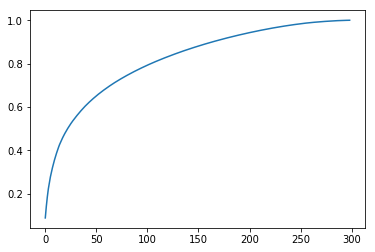

In [13]:
pca_model = PCA(n_components = 299)
pca_results = pca_model.fit_transform(vectors)

sns.lineplot(data = np.cumsum(pca_model.explained_variance_ratio_))

150 principal components chosen as it retains the ~90% of the variance

TSNE is then used to reduce further to 2 dimensions. Perplexity of 50 is chosen after various trials

In [14]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300, random_state=7)
tsne_results = tsne.fit_transform(pca_result_150)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 13022 samples in 0.108s...
[t-SNE] Computed neighbors for 13022 samples in 86.509s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13022
[t-SNE] Computed conditional probabilities for sample 2000 / 13022
[t-SNE] Computed conditional probabilities for sample 3000 / 13022
[t-SNE] Computed conditional probabilities for sample 4000 / 13022
[t-SNE] Computed conditional probabilities for sample 5000 / 13022
[t-SNE] Computed conditional probabilities for sample 6000 / 13022
[t-SNE] Computed conditional probabilities for sample 7000 / 13022
[t-SNE] Computed conditional probabilities for sample 8000 / 13022
[t-SNE] Computed conditional probabilities for sample 9000 / 13022
[t-SNE] Computed conditional probabilities for sample 10000 / 13022
[t-SNE] Computed conditional probabilities for sample 11000 / 13022
[t-SNE] Computed conditional probabilities for sample 12000 / 13022
[t-SNE] Computed conditional probabilities for s

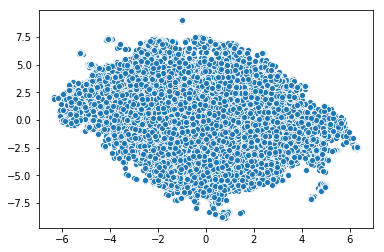

In [15]:
# Plot the 2d vector representations to check for formation of clusters and patterns

tsne_one = tsne_results[:,0]
tsne_two = tsne_results[:,1]

sns.scatterplot(x = tsne_one, y = tsne_two)

### 3.3 Clusterisation<a class="anchor" id="3.3"></a>
DBSCAN algorithm used as k does not need to be specified. Moreover, it is able to discern articles that do not belong to any cluster. However, epsilon parameter that determines the size of the cluster needs to be fine-tuned. This is done by trying for various epsilons within a range.

In [16]:
# Try DBSCAN clusterising algorithm for various values of epsilon
n_classes = {}

for i in np.arange(0.001,0.2,0.0002):
    print(i)
    dbscan = DBSCAN(metric='euclidean',eps=i, min_samples=2).fit(np.array(np.array(tsne_results)))
    n_classes[i] = len(set(dbscan.labels_))

0.001
0.0012000000000000001
0.0014000000000000002
0.0016000000000000003
0.0018000000000000004
0.0020000000000000005
0.0022000000000000006
0.0024000000000000007
0.0026000000000000007
0.002800000000000001
0.003000000000000001
0.003200000000000001
0.003400000000000001
0.003600000000000001
0.0038000000000000013
0.004000000000000002
0.0042000000000000015
0.004400000000000001
0.004600000000000002
0.004800000000000002
0.005000000000000002
0.005200000000000002
0.005400000000000002
0.005600000000000002
0.005800000000000002
0.006000000000000003
0.006200000000000002
0.006400000000000002
0.0066000000000000026
0.006800000000000003
0.007000000000000003
0.007200000000000002
0.007400000000000003
0.0076000000000000035
0.007800000000000003
0.008000000000000004
0.008200000000000002
0.008400000000000005
0.008600000000000003
0.008800000000000002
0.009000000000000005
0.009200000000000003
0.009400000000000006
0.009600000000000004
0.009800000000000003
0.010000000000000005
0.010200000000000004
0.01040000000000

0.08120000000000004
0.08140000000000004
0.08160000000000003
0.08180000000000004
0.08200000000000003
0.08220000000000004
0.08240000000000004
0.08260000000000003
0.08280000000000004
0.08300000000000003
0.08320000000000004
0.08340000000000004
0.08360000000000004
0.08380000000000004
0.08400000000000003
0.08420000000000004
0.08440000000000004
0.08460000000000004
0.08480000000000004
0.08500000000000003
0.08520000000000004
0.08540000000000005
0.08560000000000004
0.08580000000000004
0.08600000000000003
0.08620000000000004
0.08640000000000005
0.08660000000000004
0.08680000000000004
0.08700000000000004
0.08720000000000004
0.08740000000000003
0.08760000000000004
0.08780000000000004
0.08800000000000004
0.08820000000000004
0.08840000000000003
0.08860000000000004
0.08880000000000005
0.08900000000000004
0.08920000000000004
0.08940000000000003
0.08960000000000004
0.08980000000000005
0.09000000000000004
0.09020000000000004
0.09040000000000004
0.09060000000000004
0.09080000000000005
0.09100000000000004


0.16300000000000006
0.16320000000000007
0.16340000000000007
0.16360000000000008
0.16380000000000008
0.16400000000000006
0.16420000000000007
0.16440000000000007
0.16460000000000008
0.16480000000000009
0.16500000000000006
0.16520000000000007
0.16540000000000007
0.16560000000000008
0.1658000000000001
0.16600000000000006
0.16620000000000007
0.16640000000000008
0.16660000000000008
0.1668000000000001
0.16700000000000007
0.16720000000000007
0.16740000000000008
0.16760000000000008
0.1678000000000001
0.16800000000000007
0.16820000000000007
0.16840000000000008
0.16860000000000008
0.1688000000000001
0.16900000000000007
0.16920000000000007
0.16940000000000008
0.16960000000000008
0.1698000000000001
0.17000000000000007
0.17020000000000007
0.17040000000000008
0.17060000000000008
0.1708000000000001
0.17100000000000007
0.17120000000000007
0.17140000000000008
0.17160000000000009
0.1718000000000001
0.17200000000000007
0.17220000000000008
0.17240000000000008
0.1726000000000001
0.1728000000000001
0.1730000

Plot the graph to identify best epsilon

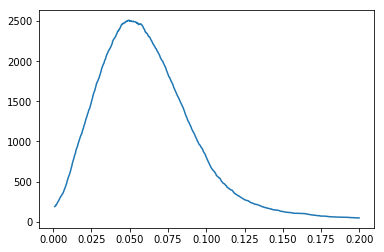

In [17]:
sns.lineplot(x=list(n_classes.keys()), y = list(n_classes.values()))

Perform DBSCAN once again and compile results into a dataframe

In [18]:
dbscan = DBSCAN(metric='euclidean',eps=0.05, min_samples=2).fit(np.array(np.array(tsne_results)))
# dbscan = DBSCAN(metric='euclidean',eps=0.03, min_samples=2).fit(np.array(np.array(tsne_results)))

In [19]:
# Get reduced vectors 
reduced_vec = [np.array(vec) for vec in tsne_results]

In [20]:
# Compile results into a dataframe
results = pd.DataFrame({'sentences':sentences,'preprocessed':preprocessed_articles, 'vectors':vectors, 'red-vectors':reduced_vec, 'descriptions':articles['ArticleDescription'], 'labels':dbscan.labels_, 'published':articles['ArticlePublishedTimeDateTime']})

In [22]:
results.labels.value_counts()

-1       4280
 1        182
 235      166
 27        68
 66        58
 81        53
 156       52
 24        48
 1238      36
 1438      33
 26        33
 123       33
 2055      32
 871       31
 38        30
 41        27
 2451      27
 730       26
 185       25
 3         25
 773       25
 30        23
 1516      23
 65        22
 298       22
 20        17
 1638      16
 475       15
 611       15
 2404      15
         ... 
 1540       2
 1548       2
 1172       2
 1148       2
 1140       2
 1116       2
 708        2
 716        2
 740        2
 756        2
 764        2
 780        2
 788        2
 796        2
 828        2
 836        2
 860        2
 868        2
 884        2
 892        2
 940        2
 988        2
 1012       2
 1028       2
 1044       2
 1060       2
 1068       2
 1092       2
 1100       2
 0          2
Name: labels, Length: 2507, dtype: int64

There are a total of 2507 clusters with 4280 articles not belonging to any cluster

### 3.4 Evaluation<a class="anchor" id="3.4"></a>
As there is no established method of evaluating our final clusters as the dataset is unsupervised, I have defined a function that outputs the average semantic similarities for articles that have been clustered together. A value of 1 meaning the text has very high similarity and a value of 0 meaning they have nothing in common at all from a text point of view.

In [27]:
def find_similarity(articles):
    nlp_articles = [nlp(article) for article in articles]
    total = 0
    no = 0
    for i in range(len(nlp_articles)-1):
        for j in range(i,len(nlp_articles)):
            total += nlp_articles[i].similarity(nlp_articles[j])
            no += 1
    return total/no

In [28]:
# Apply function to evaluate all the clusters
evaluation = pd.DataFrame(results.groupby(['labels'])['preprocessed'].apply(find_similarity))

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

In [29]:
print('Ratio of clusters accurately clustered:', evaluation[evaluation['preprocessed']>0.85].count()/(evaluation.shape[0]-1))

Ratio of clusters accurately clustered: preprocessed    0.189944
dtype: float64


As you can see, only 20% of the clusters can be considered to contain articles that are at least 85% similar to each other. This indicates the method of relying on the vector representations of the articles alone with DBSCAN is not sufficient in properly clustering these articles.

Maybe I should consider grouping by time first before applying the clustering algorithms?

In [30]:
np.mean(results[results['labels'].isin(evaluation[evaluation['preprocessed']>0.85].index)].groupby('labels')['published'].apply(lambda x:max(x)-min(x)))

Timedelta('0 days 12:46:33.069327')

Calculations show that the average time between articles for the accurate clusters is 13 hours. Since the total range is 2 days, it is not beneficial to use time to pre-cluster the articles.

Considering that a pure vector embedding clustering algorithm only reveals subpar results, maybe a more manual form of clustering first should be attempted ie. according to named entity recognition. This would also help in extracting information about the news articles as part of the second challenge

## 4. Hiearchical Clustering<a class="anchor" id="4"></a>
Since a pure vector embedding clustering resutled in less than ideal results, I will first cluster the articles based on named entities found in the article titles. From those clusters, I will then reapply the clustering method as in Section 4. The pipeline is as follows:

1. Apply preprocessing and fined named entitites in article and get the vector embeddings for the named entities.
3. Perform dimensionality reduction (to speed up clustering process) and cluster based on the named entity keywords.
4. Clusters that have low similarity are then re-clustered based on Section 4
6. Perform second-stage clusterisation using DBSCAN algorithm
7. Evaluate the final clusterisation using similarities

### 4.1 Preprocessing and Finding NER (Named Entity Recognition)<a class="anchor" id="4.1"></a>
I will make use of Spacy's NER model to collect the NER keywords and store them in a list of tuples. There are multiple things to consider when using this method. First I will split the articles which have detectable NER keywords from the articles which have no detected keywords. The latter will have '-1' assigned as the cluster label to their article. This is to reduce noise when doing the first stage clustering. The dataframes will then be joined back together after the initial clustering for intermediate evaluation

In [31]:
ner_vec=[]
docs = []
type_dict = {}
preprocessed_articles = []
count = 0
for article in articles.ArticleTitle:
    doc = nlp(article)

    tokens = [token.text for token in doc if not token.is_stop and token.text.isalpha()]
    new_article = ' '.join(tokens)
    preprocessed_articles.append(new_article)

    doc = nlp(new_article)
    ner = []
    types = ['PERSON', 'ORG', 'NORP', 'LOC', 'GPE']
    tmp = ''
    for i in range(len(doc)):
        if doc[i].ent_type_ != '':
            tmp += ' '
            tmp += doc[i].text
    docs.append(doc)
    ner_vec.append((tmp, nlp(tmp).vector))

 Lowestoft
 Met Gala Game Thrones
 prom day
 Paddy Jackson
 BAFTA TV Awards Stars Eve
 Poe Mother Day
 Pep Guardiola Man City Liverpool
 Lewis Capaldi Chris
 Hamill
 Turkey
 Turkey
 Steven Gerrard Jordan Jones Jake Hastie
 Arsenal Tottenham Premier League final day
 Canada
 ASVEL Villeurbanne French Cup

 Richie Ramsay Robert MacIntyre British
 Rangers vs Celtic Old Firm Ibrox
 bin Waitrose London
 Jeremy Corbyn UK
 NAPLAN
 Meghan Markle Trevor Engelson
 WWE Jake Hager MMA Jones
 Wes Foderingham Steven Gerrard Rangers
 UK
 Premier League Manchester City Liverpool
 Hughes
 Prawn Coconut Curry
 Meghan Harry Mother Day
 Theresa Conservatives Brexit
 Premier League Liverpool Man City
 Jurgen Klopp Oktoberfest WOOED Liverpool
 Meghan Harry Mother Day
 Canada
 Maduro Venezuela
 Utd Cardiff TV channel TV Man Utd Cardiff Premier League
 South Africa ANC
 Gemma Collins TOWIE tonight Arg
 Soudan du Sud la
 Joanna Cherry
 Neil Lennon Celtic
 Wicklow Mountains
 Rangers vs Celtic LIVE SCORE Live Ib

 Orrington Bangor
 Sunday UK Jim Ratcliffe
 Tottenham Christian Eriksen Madrid
 Burger King McDonald
 YouTube James Charles Tati Westbrook
 Ibrox Stadium

 Dumelo
 Meghan Markle Prince Archie Birth Palace
 Tim Ryan
 Paul Dogboe Isaac Dogboe Navarette
 Jo Sullivan Loesser Broadway
 years
 Barcelona Getafe Suarez Dembele

 Ataman Efes
 Katsina
 Iloilo
 Vancouver Canadian summer
 Utd Cardiff City
 Motley Fool
 Brighton nights row Manchester City Liverpool
 Hours
 Bodyshamed
 million
 Arsenal Pierre Emerick Aubameyang Alexandre Lacazette
 Meghan Markle
 Leicester City Chelsea LIVE

 Zion McHenry
 Manny Pacquiao Keith Thurman
 Myanmar National Airlines
 Tottenham Daniel Levy
 Border Force
 Brazil
 Neil McCann Rangers Celtic
 Refugee Afghan Turkey
 Netanyahu Israel
 Steven Gerrard Steven Gerrard
 RTE
 million
 Sydney Melbourne Victory League Big Blue
 Man City Liverpool
 Liverpool UK Premier League
 CID
 Dundee Jim McIntyre
 British Leinster
 Vissel Kobe Serginho
 Duchess Sussex LA
 Birmingh

 Leicester City Chelsea
 Premier League mm
 Rangers Celtic Rangers
 Brighton Manchester City Riyad Mahrez Kevin De Bruyne Premier League
 SK
 Houston Channel
 Huddersfield Southampton
 Lyft
 Premier League LIVE Liverpool Wolves Man City Brighton
 Joe Willock Arsenal Burnley
 Japanese
 Van Dijk
 Utd Gunnar Solskjaer Cardiff
 Australia
 Sadio Mane Watch Liverpool Reds Wolves Premier League final day
 Steven Gerrard Celtic Boyd
 North Macedonia Stevo Pendarovski
 Final Day Arsenal Utd Chelsea
 Didiza
 Nigeria sept morts dans deux
 Dallas Old East Dallas
 Sydney
 Premier League LIVE

 Angel Gomes Man Utd Cardiff
 Nigel Farage BBC Andrew Marr
 Barry Didcock TV BBC
 Saturday
 Britain Talent David Walliams
 EuroLeague Argentina
 EPL Stats
 Neymar PSG
 ParentsNext Balance
 Steven Gerrard Celtic
 Max Verstappen Dilara Sanlik Red Bull
 Pope Francis Vatican
 Rangers Celtic Celtic
 Barcelona Liverpool Matthijs de Ligt
 Calgary
 Rent Runway Amazon San Francisco
 Josie Johnson
 Lyra McKee Theresa
 C

 Navy Identifies USS Wasp Sailor Found Dead Public Park Sasebo Naval Base
 Jessie J
 Nana Aba Anamoah
 Blantyre
 Tottenham Everton Christian Eriksen Spurs Champions League
 France Czech Republic Euros

 Day Spring
 British
 half UK
 Shelocta Indiana County
 Locking Miro Stars John Klingberg


 Hamilton Bottas Monaco Grand Prix sixth Mercedes
 South Placer Family
 Trump

 Patriot Act Hasan Minhaj Duterte


 Freddie Starr
 Rocklin Quarry Park Adventures
 Scotland
 Year
 McNamara Waiting Tomkins
 Liverpool Sadio Mane Man City Premier League
 Pampanga
 China years ago
 Ethiopia


 Silicon Valley Australia
 Premier League Liverpool Manchester City
 Britain Education
 Premier League Aguero Mane Aubameyang Golden Boot
 Whitehall
 Lewis Hamilton Spanish Grand Prix
 Liverpool John Barnes Reds Anfield
 Bradford
 Dave
 Nike Air Force Low Premium Selvedge Denim
 Burkina Faso
 Man City Yaya Toure
 Judy Judy Garland
 Logan Couture Sharks NHL

 Ken Holland Edmonton Oilers Things
 Miraa
 Troy Deeney F

 Chelsea Liverpool Leicester Manchester City
 David Pratt America Dark Prince
 Pep Guardiola Man City Premier League
 Turkey Cypriot
 Newcastle Fulham Rafael Benitez
 Man City Brighton Premier League
 Border Force Kent
 Christian Eriksen Tottenham Champions League
 Tottenham Everton Spurs Champions League Final
 Baby Archie
 Huddersfield Southampton
 Liverpool SWAP Jamie Carragher
 Wilfried Zaha
 Arsenal Burnley Pierre Emerick Aubameyang

 Utd Ole Gunnar Solskjaer Cardiff

 Saskatoon Westmont
 EastEnders Ewan Riley Jones Lola
 Trump China
 EPL
 Defiant Liverpool Euro
 China Trump
 Alexandria Ocasio Cortez Nina West
 Man City Brighton Premier League
 Marcio Lassiter
 Paul Pogba
 Chelsea Premier League Leicester
 Manchester United Premier League Cardiff
 Aubameyang Golden Boot Arsenal Burnley
 Joanna Cherry Ian Blackford
 Brexit
 Shepherd
 Matteo
 Liverpool
 Liverpool Anfield Sadio Mohamed Salah Golden Boot
 Martin Compston James Bond Bafta TV Awards


 Horoscope
 Canada Jennifer Jones K

 Students University Calgary

 BAFTA TV Awards Emily Atack Rob Jowers
 Israel Golan Donald Trump
 University Calgary
 Crystal Palace year Selhurst Park

 BAFTA TV Awards
 Premier League
 Ole Manchester United Paul Pogba Real Madrid Cardiff
 London

 Luka Samanic NBA Draft Combine
 Remy Lille Champions League
 Brit
 Roma Juventus LIVE Team news TV
 Iran Iranian
 Wine Pete Stewart

 Asamoah Gyan Kayserispor
 Peter Mansbridge Bieber
 Gallery Pep
 Collins SC Paderborn Cusp Bundesliga
 Ackermann Giro Simon Yates second
 Sarri Chelsea Real Madrid
 Premier League
 Calgary
 Projet de pont Kinshasa Brazzaville
 Arbour Lake
 Arbour Lake

 Sterling Man City Twitter
 Lennon Celtic
 Utd Solskjaer
 Minneapolis
 Maldon Mud Race hundreds Essex
 months
 Mason Greenwood Gunnar Solskjaer
 Yaya Toure years
 Control Bus Havoc Philippines
 Trump Larry Kudlow
 North Berwick
 Waze Pandora
 David Harewood
 AirPods MacBook
 Fullerton Markets App PipProfit
 Texas Slocum

 Utd Declan Rice West Ham Manuel Pellegri

 Playoff Games Absa Prem Fight Begins

 Travelex

 Ujah Double Sinks Frankfurt
 London
 Jürgen Klopp Liverpool Manchester City
 Balfour
 Buhari
 Kurtenbach Derek Holland Giants
 Obafemi Hamzat Lagos
 Kirsty Gallacher Sky Sports Natalie Pinkham Dubai
 Archant
 BRODBECK Health Winnipeg
 Kananaskis
 Corfu
 European
 Hunt
 League Ramsey Mata
 Freddie Starr
 Dallas
 Corbyn
 Wednesday
 Penn Township
 Gabrielle Union Jessica Alba
 vous offre vos Love Green
 Wrestler Silver King years

 Singapore SG Digital Wonderland


 Madrid
 million Talent Community Connections
 Stephen Sutton

 Burkina Faso
 Le Espagne
 Élections

 UE ces

 Anderson
 Le kebab ce
 HANNEN Municipal
 Serena Tejpar

 Calum Best Rangers Brian Matthews Glasgow
 Calabar
 Metro
 Indonesia Dubai
 Facebook Italian EU
 Melbourne Express Monday
 HGP Turbo Volkswagen Golf R HP Hits MPH Seconds
 Phillip Schofield Molly Magaluf
 Heartbroken Wicklow
 Kevin Maguire British
 BAFTA TV Awards Ant Dec
 Crystal Palace Selhurst Park
 Ole Gunnar

 Monessen Mother Day
 Robbie Williams

 European Union Kenya



 Myanmar
 Rafael Nadal Madrid
 Sophie Pascoe
 Moore Good Standing
 Mercedes Lewis Hamilton Ferrari
 Richard Buxton
 Cardiff City Manchester United
 Neil Humphreys Pep
 Lampard
 Liverpool Man City
 Salford
 Bayern Munich Borussia Dortmund Watzke
 UN
 Trump China
 Pakistan
 Durian Australian
 Delhi


 PMD
 Red Cross
 PM Mother Day
 OCBC Cycle
 bicentennial Singapore
 Tan Chuan Jin
 Tom

 Geylang Serai Bazaar Tradition Keeps Times
 Fitrah Muslim
 Kallang

 Silicon Valley
 million
 UAE Utico Hyflux
 week
 Uber IPO

 Foodfare
 Foodfare

 Cleo Eligible Bachelors

 Kim Kardashian

 Sono Motors
 Expedia


 Iran
 Hilton
 Toyota
 Hugh Hewitt Senate Donald Trump
 million

 New York
 World War II Navajo Code Fleming Begaye Sr Dies

 David Beckham Brooklyn month
 Bafta TV Awards Graham Norton Freddie Starr
 Alesha MacPhail
 Hertha Covic

 Russia

 Iran Trump
 Annual East Java

 Ole Gunnar Solskjær Manchester United
 SIMMONS London Loga

 weeks India
 China Trump
 opening day
 Rangers Rougned Odor
 NBC year years
 half
 Silver King Probe London
 Deep South Midwest
 Kentucky Islamic
 Raila Ruto Uhuru Kenya
 Lebanese
 Negros Occidental Election Day
 South Korea
 South Africa
 PNP
 Australian Japan
 Cardiff
 Israel Folau Rugby Australia
 Melissa McCarthy Steve Harvey

 Cebu Osmeña Labella post Game Thrones
 Lattice
 Kelley Blue Book
 TripAdvisor

 Week Decade

 Nadalie Dias

 Bafta TV Awards EastEnders Coronation Street



 Carat Michael Epstein
 Juventus Roma Italian half half
 VRV San Fernando
 Watford Javi Gracia Jose Holebas West Ham FA Cup
 South



 Ejercito San Juan
 Qantas Points Plane Seats
 Lithuania Saulius Skvernelis
 Taiwan
 Monday
 Monday
 Game Thrones
 Filipino election day
 Martian moon
 Asia
 Good Girls Land Land Review
 Australia
 Heppell Fantasia
 Robert De Niro Brit Warburtons
 Algorithm Netflix
 Leonard Bailey Loma Linda University Baby Fae

 CJ McCollum Blazers Nuggets
 European Tom Watson Labour
 Sc

 Rigoletto Melbourne
 Prince Albert Game WHL

 second Burkina Faso
 STINSON Kawhi
 Saudi
 UK Britain Benidorm
 Dennis Smith Mavs
 Pompeo Iran Brussels Russia
 Abby Binay Makati
 Day Jasmine Lovett
 OSF

 TEAM Remembering
 China
 Saudi UAE Energy
 Sara Election Duterte
 IVCC English
 Ottawa
 CLUB Sons Norway
 Livewire Eagle Willie Rioli
 WA
 Sunday
 Sunday
 Streator Rigazio
 League Legends
 dozens Wajir
 Giants Hawks Bartel
 Dominic Breazeale Deontay Wilder
 Jaime Season
 Disney Singapore annual

 Nabongo days
 Kenya
 Iten IAAF
 Jurgen Klopp Liverpool Man City
 Indian
 Eden Hazard


 Google


 Amazon

 Autotrader Discovery
 Jesus

 Pius XII Fatima Vatican
 Mother Day
 Jennifer Lawrence Dior Montaigne Parisian
 Singapore

 Digiday Research
 Dyson Absolute
 Boyolali Idul Fitri
 Ikhsan Fandi Norwegian Raufoss
 CBS News CBSN million

 GroupM Susan Schiekofer
 YouTube
 Muslim
 Palmer Queensland
 Manchester City Liverpool
 VAR minutes CSL

 Leni Robredo Naga City
 Hayward

 South Korea
 Grace

 Yaya Toure Man City Barcelona
 Megan Barton Hanson
 Apple Apple Cards

 Saudi UAE

 Wayne LaPierre hundreds thousands NRA
 Singtel Telkomsel
 Liverpool Jurgen Klopp
 Robredo
 Thousands Kenyan China Beijing
 Paul Pogba Utd
 Carlos Ghosn Nissan
 Pasig Vico Sotto
 Orkney
 Erap Estrada Manila San Juan

 Comelec Duterte
 Kenya Great Lakes Region

 Felicity Huffman
 Garcia Cebu
 Day
 Day
 Meghan Markle million dollar
 Sweden Julian Assange
 Jack McConnell second Holyrood

 Premier League Pep Guardiola Manchester City

 Hotels Pledge Reduce Plastics
 Stanford


 BAFTA Paul Chuckle Barry
 Finks
 UK
 Philip Green
 Albanian
 Alan Cayetano Taguig
 TUI
 Chris Coleman China
 Paris
 Нотр Дам Стеклопластиковая
 Coutinho Chelsea Liverpool
 German
 EU
 Witherford Watson Mann East Midlands

 Iran
 Dubai
 Forest Green vs Tranmere TV
 Eton Harrow
 Kean
 Trump Hungary Viktor Orban
 Comelec
 Messi

 Madrid
 Burger Impossible Foods versus Meat
 Days SoftBank billion

 IOOF ANZ
 Sri Lankan
 Tory Luke Graham


 Northern Samar
 Quebec

 Canada Tokyo Olympics
 LIVESTREAM PIC Inquiry week
 EU Tories FIFTH
 Lagos
 Sung Kang Byron Nelson
 Художник Дэвида

 NCRPO Eleazar Crisologo
 Вышел Мертвые
 Icelandic BDSM Eurovision Israel
 Rafael Nadal Mery Perello
 Stroili

 Huawei Singapore
 Tavares Tobey ACB Round MVP
 European Tories fifth Farage Brexit Party

 Singapore Huawei Amber Sunrise Pro
 HTC Bitcoin
 Burmese

 Tories

 British

 EU year
 Nigel Farage

 Sydney future night
 Ariana Grande Givenchy
 Ranbir Kapoor Ae Dil Hai Mushkil

 Celtic Gascoigne
 Coca Cola
 Bafta TV Awards Holly Willoughby
 Youtube
 Indonesia Environmentalists
 Pimentel Comelec

 Scotland UK
 Instagram
 Air India
 Amber Davies Boohoo party Lottie Moss Olivia Attwood
 Olivia Attwood Boohoo
 Mark Wright LA Ashley James Christina Milian
 Ice Kem Cetinay
 Bohol
 Theresa weeks
 Turkish Cyprus
 Bafta TV Eve
 FALSE Villegas Otso Diretso
 Philippines Duterte

 Liverpool John W Henry Man City
 Bafta TV Awards Declan Donnelly Holly Wil

 Bafta TV Awards Dec Donnelly Holly Willoughby
 Freddie Starr Elvis Presley Costa del Sol

 Odibe Relishes Northern Cyprus League
 Joanna Cherry
 Sweden Julian Assange
 Madrid
 Aberdeen
 FALSE Daily Guardian Gorricetas Biron
 Holebas FA Watford
 IRGC Iran
 Sweden Julian Assange
 Bros Luke Goss Shirley Lewis
 Utd season summer
 Travis Scott
 Benitez Coy Newcastle
 Burkina Morning
 Manchester United Zlatan Ibrahimovic Adidas
 À Jérusalem
 Une fille de Dos Santos en exil Royaume Uni Morning
 Museveni appelle les Africains à supprimer
 Andros Townsend

 TalkTalk Heart Breakfast
 Metro Bank

 years
 years millions
 Swedish Julian Assange
 Kanye West Pays Sunday
 Jeremy Kyle ITV

 Wa Muchomba
 David Schwimmer Baftas
 Kangde Xin
 Graham Potter Brighton Phil Neville Laurent Blanc Chris Hughton
 Terry Gou Taiwan
 Steven Anderson Ireland
 Opel Combo
 China Labor Liberal
 Manchester United Jose Mourinho Madrid Gareth Bale
 Zlatan Ibrahimovic Manchester City Adidas half Nike
 Chelsea British Nike


 Stoke Hull Oldham George Edmundson
 Comelec VP Binay
 day
 Amazon

 KZN
 Monday
 Bleecker Street Toni Collette Damian Lewis Horse Cannes
 SIM hundreds years
 Tade Ogidan Gold Statue Nollywood
 YouTuber James Charles Tati Westbrook
 Jeff Goldblum Lobotomist Mountain
 Tricolor Stripe Stan Smith
 Foxconn Terry Gou Taiwan
 summer
 Johannes Witteveen Economist Britain

 Doncaster
 Coffee Claressa Harry Fane
 Toddler SEAGULL Greggs
 Jeremy Kyle
 Chris Packham

 Spirits Sarries Champions Cup Final

 Queensway Shopping Centre
 Silicon Valley
 Jeremy Kyle

 Cannes
 Maplewood
 Amazon millions
 Amazon millions
 Pierre Emerick Aubameyang Africa Liverpool Mohamed Salah Sadio Mane
 Jeremy Kyle

 Sun
 Philippine
 Ghanaians Ghana
 Bilal Hassani France
 Prince William Katy Perry Alesha Dixon Mental Health Awareness Week

 Pakistan

 Guardiola Man City
 YouTube
 Horses Heart Britain
 Kieleweke Tanga Tanga
 Watford Jose Holebas FA West Ham

 Cagayan
 Chelsea Danny Drinkwater
 Rafa Benitez Newcastle Unit

 Zimbabwe
 Poem week Finuala Dowling
 Scotland Shelley Kerr
 Tale Innocence
 Aldi Harry Potter
 Higgins Greens Liberals

 China
 Leinster Champions Cup Munster
 Wilkinsburg

 Naomi Campbell
 Jeremy Kyle
 Troy Townsend Brighton Chris Hughton
 Chris Hughton Brighton
 Kemuning


 Irish Ireland Barcelona Met Eireann scorcher week

 Andras Schiff Wigmore Hall
 Huawei
 Huawei
 London Bridge
 Liverpool Premier League Manchester City
 IBP Bikoy
 Tati Westbrook James Charles MILLION
 Sweden WikiLeaks Julian Assange
 Dior Tiepolo Ball Karlie Kloss Sienna Miller Tilda Swinton Venice Biennale
 UK
 SAS Anthony Middleton Gers Armed Forces Celtic Jamie Murphy

 SGX
 Shatta Wale Samini Stonebwoy IRAWMA
 Manchester United Ole Gunnar Solskjaer Cardiff

 Competition Rail Baltica Tallinn
 China
 John Smith Brexit

 Amazon Prime Video
 Billy Vunipola Saracens Champions Cup
 Marko Arnautovic West Ham
 Donald Trump China
 Lyons
 Rangers Charity Foundation Ant Middleton Ibrox
 Kenya
 SA

 Elon Musk SpaceX
 Qu

 Metro Bank WhatsApp
 Lewis Clark Shape American English
 Japan
 British Barclay French
 million
 Onex WestJet Corporate Canada China
 Gerald Socmed
 China
 Trump China billion
 Komphela Ea Lla Koto
 PSL
 Ibrox
 Casco Bay
 India Locus million
 Longfields early morning
 Idris Elba
 Swedish
 Britons
 Chuck D Scottish
 Ireland
 Indonesian
 Gus Frerotte Dolphins Ryan Fitzpatrick
 Amazon
 Medina March Goliad
 Week
 Frankie Benny
 Chelsea
 WhatsApp Metro Bank
 Chimp
 Djokovic Madrid second French Open
 Julius Malema Helen Zille UCT

 Martin Amidu Ghanaians
 Old JM Memorial Hospital Nyandarua
 Charles Park Ridge
 Nissan Renault
 Cannes
 Italian Kyle Edmund Fernando Verdasco Rome
 Everton Liverpool Manchester City Goodison Park
 Maisie Williams day




 German

 Scots Firefox UK
 Mahathir Star
 Kenya billion
 Game Thrones
 Rupert Murdoch News Corp
 Department Agriculture Food Marine Met Eireann
 Steph Seth Curry
 Ramaphosa Mbeki
 Eurovision Tel Aviv
 Brits Firefox UK
 Aubameyang Golden Boot Af

 Google
 SQ

 Isko Moreno Manila

 Chelsea Real Madrid

 Kenyan million

 Colliers Debenhams
 George Edmundson Hummel Training Centre Gerrard

 EU Trump

 Doris
 Charles million
 NYT Russia
 Tamboesies

 Japan
 Glastonbury
 London Bridge Sara Zelenak
 Dennerby Oshoala Ebi Oparanozie
 Disneyland
 Madrid Chelsea

 Conor McGregor
 Douglas Todd Toronto Vancouver

 Tony Stark Peter Parker Endgame
 Jewish MEP Brexit Party London
 Imran Khan Pakistan
 UMS
 Ireland Christian
 EU
 Obituary Doris Day America
 Nigel Farage
 Doris Day

 summer
 Gargasoulas
 Morrison
 billions Peak

 Whiteley million
 Fox
 Iran years UK
 Pikachu
 Micho Bucs
 Palace Filipinos

 Labor
 Chilean Southern California
 Kim Kardashian Trump talk day

 Mercedes C Class Alabama
 Helly Aa
 Apple ID
 expect year tick season Maine

 Michael Kors nuova Londra Con la moda
 Wall St China
 Wisconsin
 Eurovision Madonna
 China
 Germany Police
 Doris Day


 Ninja Foodi
 Zamora Estrada San Juan
 Serena Rome

 Lidl
 Matthijs de Ligt Ma

 China
 Amazon
 Wigflex Nottingham
 Hunt Hamilton

 Liverpool Anfield Wolves Brighton Man City

 London Bridge
 LGBT
 Watch National New Short Film Easy Find
 French EU
 Maine
 day year
 Girona La Liga
 Doris Day


 Pope
 Angry Game Thrones Google
 Angry Game Thrones Google

 week
 Queen Park
 ANC

 LVMH Launch Rihanna Fenty Maison Means Future Fashion Industry
 Football Pep Guardiola
 Apple TV Channels
 French
 AI
 Elton John Cena

 SA
 Mailchimp
 Doris Day Hollywood

 Drake Philadelphia Game Raptors

 Charles Twp
 Michigan John Beilein Cavaliers
 Ole Gunnar Solskjaer Daniel James Cardiff
 Golden Boot
 Scotland thousands
 Cambridge
 Delta Boeing
 Delta Boeing
 Porsha Williams
 Meet Castaways Survivor South Africa Island Secrets Tribe
 Fox Jussie Smollett
 Gatwick Airport
 Spurs Liverpool Champions League Tottenham
 Brighton Hughton Ashworth
 CPO

 Taiwanese
 night Filipinos
 Nxivm
 Ireland
 Manchester United Premier League

 NBA
 Swindon
 Samsung Galaxy Fold
 Nasa
 Maisie Williams
 Be

 Essex Market Lower East
 Oti North East Savanna Regions
 Trump
 Daenerys Targaryen Mad Queen
 Imran Maroof Afghan Taliban England World Cup
 Pope Medjugorje
 Lewis Hamilton
 Togo la ville de Lomé honore Emmanuel Adebayor

 Humanitas San Pio X Musica le tue mani


 Colorado



 Keanu Reeves Stephen Colbert
 Navy ISIL
 Norman



 Amazon
 CamSur
 Katie Price thousands Playboy
 Maine

 Derry Township

 Manchester City Liverpool Football Weekly
 Facebook
 Americans
 Ghanaian Patapaa
 Lancashire League
 half
 million
 Finnish Malkia Strikers
 London

 Barca Oshoala Women World Cup
 EuroLeague Rooks
 Massachusetts Appalachian Trail Virginia
 Apple
 Iran years Britain Tehran


 Arsenal Alan Skirton European Highbury
 Massachusetts Appalachian
 Trump
 Daenerys
 Iranian


 Harry Meghan Instagram
 Truth Tanning Beds Lies
 Ander Herrera Ole Gunnar Solskjaer
 Instagram
 Garth Brooks Heinz Field
 Jamie Benn
 Apple Samsung
 Copenhagen
 White Dee Jeremy Kyle
 Lenovo ThinkBook S ThinkPads
 Manchester 

 China
 Man Thought
 Mido

 Burger King Impossible Foods million
 Apple Apple
 Universal Sets Participants Film Writers Program Recalibrating
 Facebook North America
 Shania Twain Roxburgh Join Lionsgate Kingdom
 River Clyde
 Brighton Swansea Graham Potter Chris Hughton
 million miles England Jason Roy World Cup
 Costco America

 Apple today Apple TV Samsung
 Apple
 Paris
 Calgary
 Tuesday NAP today Callum Jamieson
 day
 Brampton
 Hamilton
 Mercedes year Lewis Hamilton
 Taika Waititi Jojo Rabbit
 Europa League
 Vancouver Island Green Party Singh
 Margaret Sullivan

 Lewis Hamilton Ferrari
 KitchenAid
 Supreme Court
 Sudan Bashir
 Warriors Blazers NBA
 Duterte SF
 Throwback Cannes Film Festival
 Cove Ottawa
 Ford San Antonio
 Barcelona Chelsea Philippe Coutinho
 James Charles
 Utd Ander Herrera Ole Gunnar Solskjaer
 Vancouver Blood Alley Square Wednesday
 Edinburgh
 Elish McColgan
 Adobe Amazon Google Magento
 Turkey Soma fifth Ankara
 Turkey Soma fifth
 Durham
 WestJet
 Google
 Apple
 

 Emmerdale Lisa Dingle Belle
 Darren Lewis
 Williams Italian
 Wallpaper
 Susan Sontag Freud
 Cudi Adidas Official Clothing Collaboration
 Sandwich Mayor
 Lenovo ThinkBook ThinkPad

 Oldest Surviving Porsche Personal Car Ferdinand Ferry
 Zero

 Ben Chestnut

 Micho Pirates
 Kabul
 Canada NYC
 Hamilton
 Throwback Cannes Film Festival
 Tozer Elementary Windsor
 Polly Hudson
 Hickenlooper Trump Uncle Nancy
 Doris Day
 Komphela Eymael
 Pitts

 Pinoys
 October
 Liverpool Champions League Tottenham

 Western University Huron University College
 Viktor Orban Donald Trump

 Amazon
 Silicon Valley Sempre Health billion
 Colin Justin Healthy
 Shell
 Kate Middleton Chelsea Flower
 Eric Yuan
 Metro Bank
 Istanbul Turkey
 Caleb Jones Evan Bouchard Joe Gambardella Ken Holland

 Pompeo EU Iran

 Craigton Glasgow

 Baylor QB Jalan McClendon Baltimore
 Trump Chinese
 Trump China Putin
 JTF
 Hawaii Days later
 New Mexico Rex
 Youth Year

 Lagos
 San Jose
 Nando Asda Lidl

 Scotland
 Liverpool Bundesliga


 Felicity Huffman months
 Slack CFO IPO
 Britain Iran
 Kidada Rashida Jones Peggy Lipton
 Charles Township
 Ajimobi
 Graham Chris Hughton Brighton
 Ifmis

 South African
 Canadian
 Carter
 Russell T Davies Queer Folk



 Sweden Julian Assange
 Hurricane Season
 Fishing Line Encircles Manhattan
 CIA

 years
 Bafta TV Awards Danny Dyer
 Joliet Region Chamber Commerce
 Final Adjusted TV Friday
 Fremont Sunday night

 Southwest Airlines Hawaii
 Nikola Jokic World Cup

 EastEnders Sharon Louise Keanu
 Pacific Motorway Sydney

 National Fire Protection Association Memorial Day
 Pittsburgh
 Theresa Brexit
 Jeremy Corbyn Labour Brexit
 Brian Walden
 MetLife Fintonic
 Kia
 NASA Mars hours
 Ex Michigan Taser
 Weatherwatch UK Norway

 Vauxhall Grandland X
 TAPPS Division years Fort Worth Saints
 Transgender Lotto

 April
 McHenry Conservation District Harvard
 RCMP
 Renée Zellweger
 China
 Tottenham Ryan Sessegnon Fulham England
 Onex WestJet Air Transat
 Onex WestJet Air Transat
 Red Dead
 Jose 

 Sri Lanka Muslim
 Arsenal Guendouzi week
 Jimmy Carter
 Kristaps Porzingis

 HP
 Brewer man Bangor

 Madrid Bale Tottenham Bernabeu
 Chaudière Bridge summer
 Duterte Davao Noy Aquino Robredo
 Okagbare Shanghai IAAF Diamond League
 Disney Fox OMD Upfront
 Disney Century Fox OMD
 Jewish

 Johnson EU

 Weather

 Russell Wilson Mother Day

 Pangilinan
 David Mundell Jeremy Corbyn Brexit
 DUI Uptown Dallas
 Crown
 James Charles Tati
 Bellroy
 Microsoft year Amazon




 China
 Martin Clunes

 Jace Frederick Gersson Rosas Timberwolves

 England Pakistan ODI TV channel Bristol
 CSC
 West Brom Aston Villa TV Championship
 Canadian

 Kidnapped
 Chelsea Europa League Loftus Cheek
 Pogba Mata Fletcher
 Ozil China Tagliafico Aubameyang
 Bill Nye
 Bill Nye
 Dow China
 Kawhi Leonard
 Ethiopian Airlines Boeing Max
 Labrador
 Bob Langeness Swedish
 Texas
 ASX
 Estradas San Juan Manila
 Stampeders
 Mexican
 hours
 Novelty daily
 Inter Milan Ivan Perisic Matteo Politano Nerazzurri Champions League
 Jess

 Woodford million

 day
 tonight Tuesday

 Cannes

 West Brom v Aston Villa James Shan Albion



 Duterte
 Group
 Day Gaza Victoria Palace
 Trump Orban Christians
 Tony Pulis Middlesbrough

 Druridge Bay


 China Bad Trade

 Times Daily Quiz Tuesday
 Spain
 Theresa


 Bar Refaeli Israel million

 Steven Naismith
 Steve Clarke Kilmarnock
 FAI
 St Mirren

 rainy day
 Lyons Daniel
 Sinn Féin North
 Shorters m Metro Bank

 Shetland Helly Aa
 Serena Williams
 Saddam Britain Iraqi
 Russian
 Ronan La Rochelle
 Robert Young Scots
 Robert Crampton Alyssa Milano
 years





 Pontefract Nigel Farage
 Paul Geaney
 Pat Flynn
 Paris Sarkozy millions


 Orban

 Antalya
 Nigel Farage

 Trump Heights Golan
 National Crime Agency
 Morten Morland Times
 Mike Dean Tranmere League
 Michael Gove
 NHS

 Meatless

 Margaret Fleming

 years
 Clutha
 McConnell second Holyrood
 Lovat
 London Bridge
 Coca Pepsi
 Huawei
 Lib Dems EU
 Leinster Jordan Larmour

 Corbyn Remainer second Brexit

 Kaia
 Johann van Graan 

 CrossFit Games Spartan Lefteris Theofanidis

 London Metal Exchange Hong Kong Asian
 Chinese Indonesia Taiwan
 Grant Stockwell

 Paul Keating Peter Dutton
 Ipswich


 Fed
 Grindr Chinese
 England
 Glencore DRC Dept Justice
 Jennifer Lawrence
 Igloos Pier

 Vaughn Palmer
 Tesla Hong Kong Shanghai
 Tuesday
 Phil Kessel

 WhatsApp Israeli
 Durant
 Alaska

 Queensland Tamil High Court
 British Airways summer
 Jimmy Carter
 Hong Kong
 Trump Iran

 Macalintal Senate
 Jimmy Carter

 NHS
 Archie Royal Family London
 Tulfo
 Telkomsel million
 Sydney

 billion Monsanto Roundup
 CME
 South Melbourne
 million
 million
 Gucci Hong Kong
 Gwyneth Paltrow half
 HBR Brown
 Mercedes

 Bayron Puerto Princesa
 Ex Mesa Vista
 Calgary daily
 Swedish
 Alliance Minerals
 Yale
 Middle East Iran American Iraq War
 Gareth Bale Real Madrid
 De Minaur Millman Rome
 Capítulo Alguien Caco
 East Mountains
 Families Hillsborough Graham Mackrell
 Tencent Music
 Malaysia Tuesday
 Trump
 Malaysia
 Ontario
 Australia Wor

 Homeland Security thousands New York Chicago Los Angeles
 anni di Cate Blanchett
 Advotics


 Metro Manila
 New Zealand
 Pep Guardiola
 Brown Hinckley Big Rock
 Missy Elliott Justin Timberlake
 Asian
 Court Apple
 Revilla PPCRV
 Game Raiders OT Hannoun
 China
 Era City
 Canadian China
 Lenovo Thinkpad Foldable Laptop Prototype Takes
 Evan Bouchard Bakersfield Condors

 North Korea Trump Kim
 China
 Sudan
 Joyette Jopson Filipina Arctic
 Foshan China Bruce Lee

 Cate Blanchett anni


 Filipinos
 George Clooney Io padrino del royal Pessima
 Antonino Cannavacciuolo
 Tokyo Shibuya Halloween
 romantico Barack Obama

 Rob Vanstone Jon Ryan
 Bundle Bethpage PGA Championship
 Tuesday Saint Matthias
 Monday

 Mahathir Johor

 Milano Orticola
 Colombia
 Jeremy Kyle Steve Dymond
 Mujiv Hataman Sitti Akbars Basilan
 Queensland

 GREE Ventures
 Trump NASA
 Tayla Harris
 WhatsApp Android
 WhatsApp

 Russian Southern Ocean Chile days
 Temasek Horizon Ventures
 UK NCA
 Thanksgiving
 Tagbilaran City



 Japanese Suruga Shinsei Bank
 Turkish
 Jade Jones Bianca Walkden Manchester


 PSG summer Gareth Bale Toni Kroos Isco
 Mike Dean Tranmere

 Trump China
 Asda Tesco Boots
 Shabaab Violet Kemunto
 Andy Robertson Manchester City Liverpool

 Hong Kong Bill
 Roundup
 George RR Martin Winds Winter
 Donald Trump Viktor Orbán White House
 Ferris Chatswood
 Exclusive JD Sports
 JLS Oritse Williams
 Man City Champions League Man Utd Arsenal
 Newcastle Rafa Benitez Celtic
 Dubai Twitter Vent
 Tuesday
 Queensland
 Mahama
 Tuesday Sweden Assange
 Trump
 Frank Lampard

 week Meteo Service
 Newcastle

 Twitter
 Premier League
 Jomon Japanese Han Chinese
 Samsung Spin Digital SES Showcase K Content Satellite
 Freddo Mr Kipling
 Barcelona Chelsea Coutinho m
 Riyad Mahrez Man City
 Robredo Otso Diretso
 PNP

 VGMA Samini
 skinnier past million years
 WEST
 Angels Shohei Ohtani
 Stanford
 Afcon Migne
 France
 EU Bulgaria
 Liverpool Barcelona Taekwondo
 Russia Venezuela Putin Maduro
 Manchester United Fe

 Jennifer Lawrence Engagement Party Dress
 Gareth Bale Real Madrid Tottenham Zinedine Zidane

 Hungry Giants

 day
 Everton Richarlison Paul Merson Twitter Sky Sports
 Brexiteers Boris Raab McVey Brexit Corbyn PM
 Brett Brown Sixers

 Volkswagen

 Layla Moran Liberal Democrat
 Chinese Hong Kong UBS
 Trump Iran Iraq
 Hong Kong China
 Negros Occidental
 Ruth Wishart Farage
 Nollywood Cannes African
 Ireland Simon Harris
 WhatsApp
 Walmart
 July

 Tallest City PLP Bishopsgate
 Trafford
 Overfinch Supersport loud

 MLS
 Akshay Kumar Vidya Balan Bhool Bhulaiyaa
 Caravan Abandoned Years Found Inside Left
 Elvis Presley
 Craigslist
 Premier League Mark Lawrenson


 Ateneo UST Season Volleyball Finals Game
 Alexandre Lacazette Barcelona Arsenal

 Garden Bridge City Hall Boris
 King College Hospital
 Huawei China

 Versailles

 Kashmir
 Road Trip Europe Day Passing Austria
 Corica Popovic League
 Erdoğan Turkey

 Krisflyer miles Singapore
 Royals Cannes Film Festival
 Tottenham Tottenham Hotspu

In [32]:
# Structure the new article dataframe
new_articles = pd.DataFrame({'sentences':sentences,'preprocessed':preprocessed_articles, 'vectors':vectors, 'red_vectors':reduced_vec, 'descriptions':articles['ArticleDescription'], 'ner': [x[0] for x in ner_vec], 'ner_vector': [x[1] for x in ner_vec],'published':articles['ArticlePublishedTimeDateTime']})

In [33]:
# Split the articles with detected NER from non-detected
ner_articles = new_articles[new_articles['ner'] != '']
non_ner_articles = new_articles[new_articles['ner'] == '']

In [34]:
ner_articles.head()

,sentences,preprocessed,vectors,red_vectors,descriptions,ner,ner_vector,published
0,Lowestoft sea wall fall cyclist rescued by friend,Lowestoft sea wall fall cyclist rescued friend,"[0.23631684, 0.0072168643, -0.11677142, 0.0810...","[-0.95047635, 1.4862908]",Coastguards praise the boy's friend for his ac...,Lowestoft,"[0.123375, -0.048802, 0.0129905, 0.07145, 0.21...",2019-05-12 10:32:10
1,The Met Gala & ‘Game of Thrones’ Feature in Th...,Met Gala Game Thrones Feature Week Comments Ro...,"[-0.024455123, 0.018904623, 0.15774563, -0.025...","[0.511102, -8.456292]","Once again, our ever-sarcastic readership have...",Met Gala Game Thrones,"[0.1171448, -0.1980326, 0.18696064, -0.1532739...",2019-05-12 10:32:43
2,Boy dies on prom day after allergic reaction t...,Boy dies prom day allergic reaction pollen cel...,"[-0.12069289, 0.22185487, -0.11352868, -0.0342...","[-1.7562965, 0.27834418]",Joe Dale's family have spoken out about losing...,prom day,"[-0.0036336668, 0.09744, 0.054966003, -0.00321...",2019-05-12 10:32:54
3,Paddy Jackson’s return to Rugby is yet more pr...,Paddy Jackson return Rugby proof misogyny goes...,"[-0.096876256, 0.15246925, -0.040465087, 0.008...","[0.7405226, -2.9175248]",He may have been found not guilty of rape last...,Paddy Jackson,"[-0.15762, 0.080698, 0.008982, -0.18954234, 0....",2019-05-12 10:33:08
4,BAFTA TV Awards 2019: Stars prepare for glitzy...,BAFTA TV Awards Stars prepare glitzy ceremony ...,"[-0.0737006, 0.01447565, 0.31495684, -0.026170...","[4.9282384, -3.586881]",Stars are preparing for Sunday night s TV Baft...,BAFTA TV Awards Stars Eve,"[-0.13373876, -0.012124996, 0.3214255, -0.0670...",2019-05-12 10:33:30


### 4.2 Intermediate Dimensionality Reduction<a class="anchor" id="4.2"></a>

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10599 samples in 0.173s...
[t-SNE] Computed neighbors for 10599 samples in 53.911s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10599
[t-SNE] Computed conditional probabilities for sample 2000 / 10599
[t-SNE] Computed conditional probabilities for sample 3000 / 10599
[t-SNE] Computed conditional probabilities for sample 4000 / 10599
[t-SNE] Computed conditional probabilities for sample 5000 / 10599
[t-SNE] Computed conditional probabilities for sample 6000 / 10599
[t-SNE] Computed conditional probabilities for sample 7000 / 10599
[t-SNE] Computed conditional probabilities for sample 8000 / 10599
[t-SNE] Computed conditional probabilities for sample 9000 / 10599
[t-SNE] Computed conditional probabilities for sample 10000 / 10599
[t-SNE] Computed conditional probabilities for sample 10599 / 10599
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.365868
[t-SNE] K

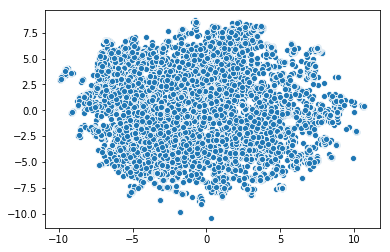

In [35]:
# Intermediate dimensionality reduction to speed up clustering algorithm
n_classes2 = {}
pca_model = PCA(n_components = 150)
pca_results = pca_model.fit_transform(list(ner_articles['ner_vector'].values))

#  TSNE just to visualise. Not used for clustering in this case
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300, random_state=7)
tsne_results = tsne.fit_transform(pca_results)

sns.scatterplot(x = tsne_results[:,0], y = tsne_results[:,1])

### 4.3 First stage clustering<a class="anchor" id="4.3"></a>

In [36]:
n_classes2 = {}
for i in np.arange(0.1,3,0.1):
    print(i)
    dbscan = DBSCAN(metric='euclidean',eps=i, min_samples=3).fit(pca_results)
    n_classes2[i] = len(set(dbscan.labels_))

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004


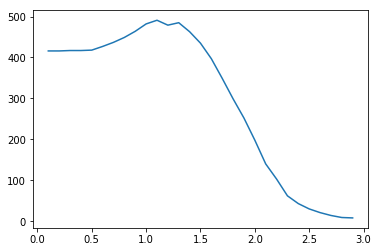

In [37]:
# Plot number of clusters agianst epsilon
sns.lineplot(x=list(n_classes2.keys()), y = list(n_classes2.values()))

In [38]:
#  Get the best choice of epsilon
for i in n_classes2.keys():
    if n_classes2.get(i) == max(n_classes2.values()):
        print(i)

1.1


In [39]:
# dbscan = DBSCAN(metric='euclidean',eps=0.07, min_samples=3).fit(tsne_results)
dbscan = DBSCAN(metric='euclidean',eps=1.1, min_samples=3).fit(pca_results)

In [40]:
# Add the labels to the dataframe. -1 automatically assigned to articles with no detected named entities
ner_articles['ner_label'] = dbscan.labels_
non_ner_articles['ner_label'] = -1

C:\Users\User\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
# Concat the two dataframes for evaluation
results = pd.concat([ner_articles, non_ner_articles]).sort_index()

In [42]:
results.head()

,sentences,preprocessed,vectors,red_vectors,descriptions,ner,ner_vector,published,ner_label
0,Lowestoft sea wall fall cyclist rescued by friend,Lowestoft sea wall fall cyclist rescued friend,"[0.23631684, 0.0072168643, -0.11677142, 0.0810...","[-0.95047635, 1.4862908]",Coastguards praise the boy's friend for his ac...,Lowestoft,"[0.123375, -0.048802, 0.0129905, 0.07145, 0.21...",2019-05-12 10:32:10,-1
1,The Met Gala & ‘Game of Thrones’ Feature in Th...,Met Gala Game Thrones Feature Week Comments Ro...,"[-0.024455123, 0.018904623, 0.15774563, -0.025...","[0.511102, -8.456292]","Once again, our ever-sarcastic readership have...",Met Gala Game Thrones,"[0.1171448, -0.1980326, 0.18696064, -0.1532739...",2019-05-12 10:32:43,-1
2,Boy dies on prom day after allergic reaction t...,Boy dies prom day allergic reaction pollen cel...,"[-0.12069289, 0.22185487, -0.11352868, -0.0342...","[-1.7562965, 0.27834418]",Joe Dale's family have spoken out about losing...,prom day,"[-0.0036336668, 0.09744, 0.054966003, -0.00321...",2019-05-12 10:32:54,-1
3,Paddy Jackson’s return to Rugby is yet more pr...,Paddy Jackson return Rugby proof misogyny goes...,"[-0.096876256, 0.15246925, -0.040465087, 0.008...","[0.7405226, -2.9175248]",He may have been found not guilty of rape last...,Paddy Jackson,"[-0.15762, 0.080698, 0.008982, -0.18954234, 0....",2019-05-12 10:33:08,-1
4,BAFTA TV Awards 2019: Stars prepare for glitzy...,BAFTA TV Awards Stars prepare glitzy ceremony ...,"[-0.0737006, 0.01447565, 0.31495684, -0.026170...","[4.9282384, -3.586881]",Stars are preparing for Sunday night s TV Baft...,BAFTA TV Awards Stars Eve,"[-0.13373876, -0.012124996, 0.3214255, -0.0670...",2019-05-12 10:33:30,0
5,LOOK: Poe shares son’s fave photo of her on Mo...,LOOK Poe shares son fave photo Mother Day,"[0.017547498, -0.057672627, -0.058337625, 0.09...","[-0.12439218, -0.914698]","Sen. Grace Poe, who is running for re-election...",Poe Mother Day,"[0.049942248, 0.115687, 0.1351725, 0.086257495...",2019-05-12 10:33:47,-1
6,Pep Guardiola 'bans Man City staff from checki...,Pep Guardiola bans Man City staff checking Liv...,"[0.08103944, 0.09979001, -0.0138119245, -0.059...","[0.3459506, -5.2838054]",Man City will win the Premier League with vict...,Pep Guardiola Man City Liverpool,"[0.14756833, 0.16822833, 0.082036935, -0.14437...",2019-05-12 10:33:59,1
7,"Lewis Capaldi, Olivia Wilde, Mena Massoud & MO...",Lewis Capaldi Olivia Wilde Mena Massoud join C...,"[-0.10508888, 0.12139556, 0.11349055, 0.127305...","[4.3787317, -2.395852]",HighlightsThe cavalcade of stars continued thi...,Lewis Capaldi Chris,"[-0.31635475, 0.21561225, 0.042385, 0.02352800...",2019-05-12 10:34:34,-1
8,Wanderers face leadership crisis as captain Ha...,Wanderers face leadership crisis captain Hamil...,"[0.049243383, -0.076481506, 0.17090599, 0.1851...","[-0.90016973, -3.9097524]",Western Sydney Wanderers captain Brendan Hamil...,Hamill,"[-0.0182965, -0.282735, -0.027796, 0.075655, 0...",2019-05-12 10:34:49,-1
9,Turkey's finance minister signals inflation ra...,Turkey finance minister signals inflation rate...,"[-0.47748238, 0.33912712, 0.160939, 0.17718527...","[-2.8479395, 5.852435]",Turkey's finance minister on Sunday said the c...,Turkey,"[-0.351405, -0.168035, 0.181405, 0.260835, 0.0...",2019-05-12 10:34:57,2


In [43]:
results.ner_label.value_counts()

-1      9638
 5       375
 21       98
 9        37
 182      34
 379      30
 92       29
 318      29
 140      29
 65       28
 7        27
 67       26
 360      25
 40       24
 6        23
 300      23
 276      23
 290      23
 44       21
 477      21
 190      20
 115      20
 87       18
 45       18
 368      18
 124      17
 76       17
 215      17
 127      17
 326      16
        ... 
 110       3
 170       3
 357       3
 186       3
 322       3
 410       3
 197       3
 394       3
 205       3
 378       3
 370       3
 362       3
 354       3
 229       3
 237       3
 330       3
 245       3
 194       3
 306       3
 298       3
 269       3
 282       3
 266       3
 250       3
 242       3
 301       3
 226       3
 218       3
 325       3
 483       3
Name: ner_label, Length: 491, dtype: int64

### 4.4 Evaluate First Stage Clustering to Prepare Data for Next Stage<a class="anchor" id="4.4"></a>
The idea of this intermediate clustering is to identify clusters that have low similarity even after clusterisation by NER. Furthermore, the 'unlabelled' clusters (-1) and underperforming NER clusters are then clustered based on their article title as well.

In [44]:
evaluation = results[results.ner_label != -1].groupby('ner_label')['preprocessed'].apply(find_similarity)

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

### 4.5 Second Stage Clustering<a class="anchor" id="4.5"></a>
First the data that requires further clustering is extracted and DBSCAN algorithm is applied again. After that, the output labels then need to be operated on to ensure each cluster is uniquely represented. Finally the data is then merged back into the original dataframe to give the final results.

In [45]:
#  Define function for clustering each ner_label
def cluster(vectors):
    n_classes = {}
    best = 0
    best_labels = 0
    for i in np.arange(0.05, 0.5, 0.05):
        dbscan = DBSCAN(metric='euclidean',eps=i, min_samples=2).fit(list(vectors))
        if len(set(dbscan.labels_)) > best_labels:
            best = i
            best_labels = len(set(dbscan.labels_))
            
    dbscan = DBSCAN(metric='euclidean',eps=best, min_samples=2).fit(list(vectors))
#     dbscan = DBSCAN(metric='euclidean',eps=0.1, min_samples=2).fit(list(vectors))
    
    return dbscan.labels_

In [46]:
# Split the dataset that requires second-stage processing
second_stage = results[(results['ner_label'].isin(evaluation[evaluation.values<0.9].index)) | (results['ner_label'] == -1)]
remainder = results[results['ner_label'].isin(evaluation[evaluation.values>=0.9].index)]

In [47]:
# Get the new labels
labels = second_stage.groupby('ner_label')['red_vectors'].apply(cluster)

In [48]:
# Transform to get unique labels
count = 0
for label in labels:
    unique = len(set(label[label != -1]))
    label[label != -1] += count
    count += unique

#     Finally transform the remainder dataset as well to get unique labels
remainder['label'] = remainder['ner_label'] + count

C:\Users\User\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [49]:
# Compile the different clusters together into a labelled dataframe
second_results = pd.DataFrame()
for index, lab in labels.items():
    tmp = second_stage[second_stage['ner_label'] == index]
    tmp['label'] = lab
    second_results = pd.concat([second_results,tmp]) if not second_results.empty else tmp
second_results.sort_index()

C:\Users\User\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,sentences,preprocessed,vectors,red_vectors,descriptions,ner,ner_vector,published,ner_label,label
0,Lowestoft sea wall fall cyclist rescued by friend,Lowestoft sea wall fall cyclist rescued friend,"[0.23631684, 0.0072168643, -0.11677142, 0.0810...","[-0.95047635, 1.4862908]",Coastguards praise the boy's friend for his ac...,Lowestoft,"[0.123375, -0.048802, 0.0129905, 0.07145, 0.21...",2019-05-12 10:32:10,-1,0
1,The Met Gala & ‘Game of Thrones’ Feature in Th...,Met Gala Game Thrones Feature Week Comments Ro...,"[-0.024455123, 0.018904623, 0.15774563, -0.025...","[0.511102, -8.456292]","Once again, our ever-sarcastic readership have...",Met Gala Game Thrones,"[0.1171448, -0.1980326, 0.18696064, -0.1532739...",2019-05-12 10:32:43,-1,1
2,Boy dies on prom day after allergic reaction t...,Boy dies prom day allergic reaction pollen cel...,"[-0.12069289, 0.22185487, -0.11352868, -0.0342...","[-1.7562965, 0.27834418]",Joe Dale's family have spoken out about losing...,prom day,"[-0.0036336668, 0.09744, 0.054966003, -0.00321...",2019-05-12 10:32:54,-1,2
3,Paddy Jackson’s return to Rugby is yet more pr...,Paddy Jackson return Rugby proof misogyny goes...,"[-0.096876256, 0.15246925, -0.040465087, 0.008...","[0.7405226, -2.9175248]",He may have been found not guilty of rape last...,Paddy Jackson,"[-0.15762, 0.080698, 0.008982, -0.18954234, 0....",2019-05-12 10:33:08,-1,-1
4,BAFTA TV Awards 2019: Stars prepare for glitzy...,BAFTA TV Awards Stars prepare glitzy ceremony ...,"[-0.0737006, 0.01447565, 0.31495684, -0.026170...","[4.9282384, -3.586881]",Stars are preparing for Sunday night s TV Baft...,BAFTA TV Awards Stars Eve,"[-0.13373876, -0.012124996, 0.3214255, -0.0670...",2019-05-12 10:33:30,0,1857
5,LOOK: Poe shares son’s fave photo of her on Mo...,LOOK Poe shares son fave photo Mother Day,"[0.017547498, -0.057672627, -0.058337625, 0.09...","[-0.12439218, -0.914698]","Sen. Grace Poe, who is running for re-election...",Poe Mother Day,"[0.049942248, 0.115687, 0.1351725, 0.086257495...",2019-05-12 10:33:47,-1,-1
6,Pep Guardiola 'bans Man City staff from checki...,Pep Guardiola bans Man City staff checking Liv...,"[0.08103944, 0.09979001, -0.0138119245, -0.059...","[0.3459506, -5.2838054]",Man City will win the Premier League with vict...,Pep Guardiola Man City Liverpool,"[0.14756833, 0.16822833, 0.082036935, -0.14437...",2019-05-12 10:33:59,1,-1
7,"Lewis Capaldi, Olivia Wilde, Mena Massoud & MO...",Lewis Capaldi Olivia Wilde Mena Massoud join C...,"[-0.10508888, 0.12139556, 0.11349055, 0.127305...","[4.3787317, -2.395852]",HighlightsThe cavalcade of stars continued thi...,Lewis Capaldi Chris,"[-0.31635475, 0.21561225, 0.042385, 0.02352800...",2019-05-12 10:34:34,-1,-1
8,Wanderers face leadership crisis as captain Ha...,Wanderers face leadership crisis captain Hamil...,"[0.049243383, -0.076481506, 0.17090599, 0.1851...","[-0.90016973, -3.9097524]",Western Sydney Wanderers captain Brendan Hamil...,Hamill,"[-0.0182965, -0.282735, -0.027796, 0.075655, 0...",2019-05-12 10:34:49,-1,-1
9,Turkey's finance minister signals inflation ra...,Turkey finance minister signals inflation rate...,"[-0.47748238, 0.33912712, 0.160939, 0.17718527...","[-2.8479395, 5.852435]",Turkey's finance minister on Sunday said the c...,Turkey,"[-0.351405, -0.168035, 0.181405, 0.260835, 0.0...",2019-05-12 10:34:57,2,1860


In [50]:
new_results = pd.concat([second_results, remainder]).sort_index()

### 4.6 Final Evaluation<a class="anchor" id="4.6"></a>

In [51]:
new_results.label.value_counts()

-1       5545
 233      111
 12        54
 52        51
 13        39
 873       34
 168       31
 1876      29
 1893      28
 38        23
 1955      23
 2694      23
 102       22
 18        22
 2388      20
 35        19
 2732      15
 2269      15
 2011      13
 2805      13
 535       13
 2259      12
 332       12
 596       12
 141       12
 1957      11
 108       11
 584       11
 11        11
 2082      11
         ... 
 1548       2
 1532       2
 1220       2
 1524       2
 1228       2
 1236       2
 1244       2
 1252       2
 1260       2
 1308       2
 1316       2
 1340       2
 1348       2
 1356       2
 1364       2
 1380       2
 1388       2
 1404       2
 1420       2
 1436       2
 1444       2
 1452       2
 1460       2
 1468       2
 1484       2
 1492       2
 1500       2
 1508       2
 1516       2
 0          2
Name: label, Length: 2504, dtype: int64

A total of 2504 clusters were formed with ~5000 of the articles not belonging to a cluster.

In [52]:
# Exclude evaluation of -1 label to reduce running time. -1 Label is naturally uncorrelated and should not be considered for evaluation
new_evaluation = new_results[new_results['label'] != -1].groupby('label')['preprocessed'].apply(find_similarity)

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\Users\User\Miniconda3\envs\ml\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main

In [53]:
print('Ratio of clusters accurately clustered:', new_evaluation[new_evaluation.values>0.85].count()/(new_evaluation.shape[0]-1))

Ratio of clusters accurately clustered: 0.34332533972821744


The hiearchical method shows that roughly 34% of the clusters are semantically accurate which is an improvement over the 20% of the previous method.

Finally, the outcome dataframe is built and saved

In [54]:
final = pd.DataFrame({'ArticleURL':articles.ArticleURL, 'ArticleTitle':articles.ArticleTitle,'ArticleDescription':articles.ArticleDescription,
                     'ArticlePublishedTime':articles.ArticlePublishedTimeDateTime, 'EventId':new_results.label})
final.to_csv('task1_outcome.csv')

## 5. Feature Extraction<a class="anchor" id="feature"></a>
The methodology for getting the main information of the clusters is to first get the mean vector of the cluster and use the Article Title that is closest to this mean. 

In [55]:
def get_mean_vector(sentences):
    a = np.zeros(300)
    sentences = list(sentences)
    for sent in sentences:
        a += nlp(sent).vector
    return a/len(sentences)

def get_central_vector(sentences):
    sentences = list(sentences)
    vecs = []
    for sent in sentences:
        doc = nlp(sent)
        vecs.append(doc.vector)
    mean_vec = get_mean_vector(sentences)
    index = pairwise_distances_argmin_min(np.array([mean_vec]),vecs)[0][0]
    return sentences[index]

In [56]:
# Find the article title that best represents the cluster
features = pd.DataFrame(new_results[new_results['label']!=-1].groupby('label')['preprocessed'].apply(get_central_vector))

The next step is to extract the time and other import named entities like people, location and organisation

In [57]:
features['EventTime'] = datetime.now()-new_results['published']

In [58]:
features['People'] = new_results.groupby('label')['ner'].apply(lambda x: set([i for i in nlp(''.join(list(x))) if i.ent_type_ == 'PERSON']))

In [59]:
features['Organisation'] = new_results.groupby('label')['ner'].apply(lambda x: set([i for i in nlp(''.join(list(x))) if i.ent_type_ == 'ORG']))

In [60]:
features['Location'] = new_results.groupby('label')['ner'].apply(lambda x: set([i for i in nlp(''.join(list(x))) if i.ent_type_ == 'GPE']))

Finally the output is saved to a csv:

In [61]:
features.to_csv('task2_outcome.csv')

# 6. Conclusion and Closing Remarks<a class="anchor" id="conclusion"></a>
- I have demonstrated that a hiearchical method of clustering performs better than a standard word2vec + dimensionality reduction solution
- Information extraction was carried out by getting the mean vector and using NER
- The task of identifying breaking news events is extremely difficult without supervised data. I was not able to come up with a method in this notebook, but it might be possible with the use of GANs or by having a trained network that can identify breaking news events.
- If there was more data, a specialised dictionary could be trained that might perform better on the dataset
- In this notebook, I didn't make much use of ArticleDescription which could be used to further differentiate the articles. One improvement might be to apply the NER to the article description instead of the title